In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim import SGD, Adam
from torchvision import transforms

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# from ray import tune
# from ray.tune import CLIReporter
# from ray.tune.schedulers import ASHAScheduler

/Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <CAE66874-17C2-35C9-9C4D-6BA9770AF17F> /Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <459875AA-DE2C-366B-9C44-90D4B3887080> /Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


## Initialise dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(size=(154, 154))
                               ])

In [3]:
class CustomDataset(Dataset):
    def __init__(self, path, transform=None, target_transform=None):
        self.transform= transform
        self.target_transform = target_transform
        self.path = path
        self.count = 0
        for i in os.listdir(self.path)[1:]: # [1:] because MacOS has .DS_Store at 0th index
            for j in os.listdir(os.path.join(self.path,i)):
                self.count += 1
        
    def __len__(self):
        return self.count
    
    def __getitem__(self, idx):
        # Lazy loading
        
        directory_idx = idx//100
        file_idx = idx%100
        
        label = directory_idx
        
        directory = os.listdir(self.path)[directory_idx + 1]
        flower_directory = os.path.join(self.path, directory)
        image_path = os.path.join(flower_directory, os.listdir(flower_directory)[file_idx])
    
        image = Image.open(image_path)
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            image = self.target_transform(image)

        return image, label
        

In [4]:
dataset = CustomDataset('tiny_FR', transform=transform)

In [5]:
torch.manual_seed(10)
index_train_test = torch.randperm(500)
index_train_val = torch.randperm(400)
data = Subset(dataset, index_train_test[:400])
data_test = Subset(dataset, index_train_test[400:])
data_train = Subset(data, index_train_val[:300])
data_valid = Subset(data, index_train_val[300:])

In [6]:
torch.manual_seed(1)
data = DataLoader(data_train, 32, shuffle=True)
data_vl = DataLoader(data_valid, 16, shuffle=True)

## Data

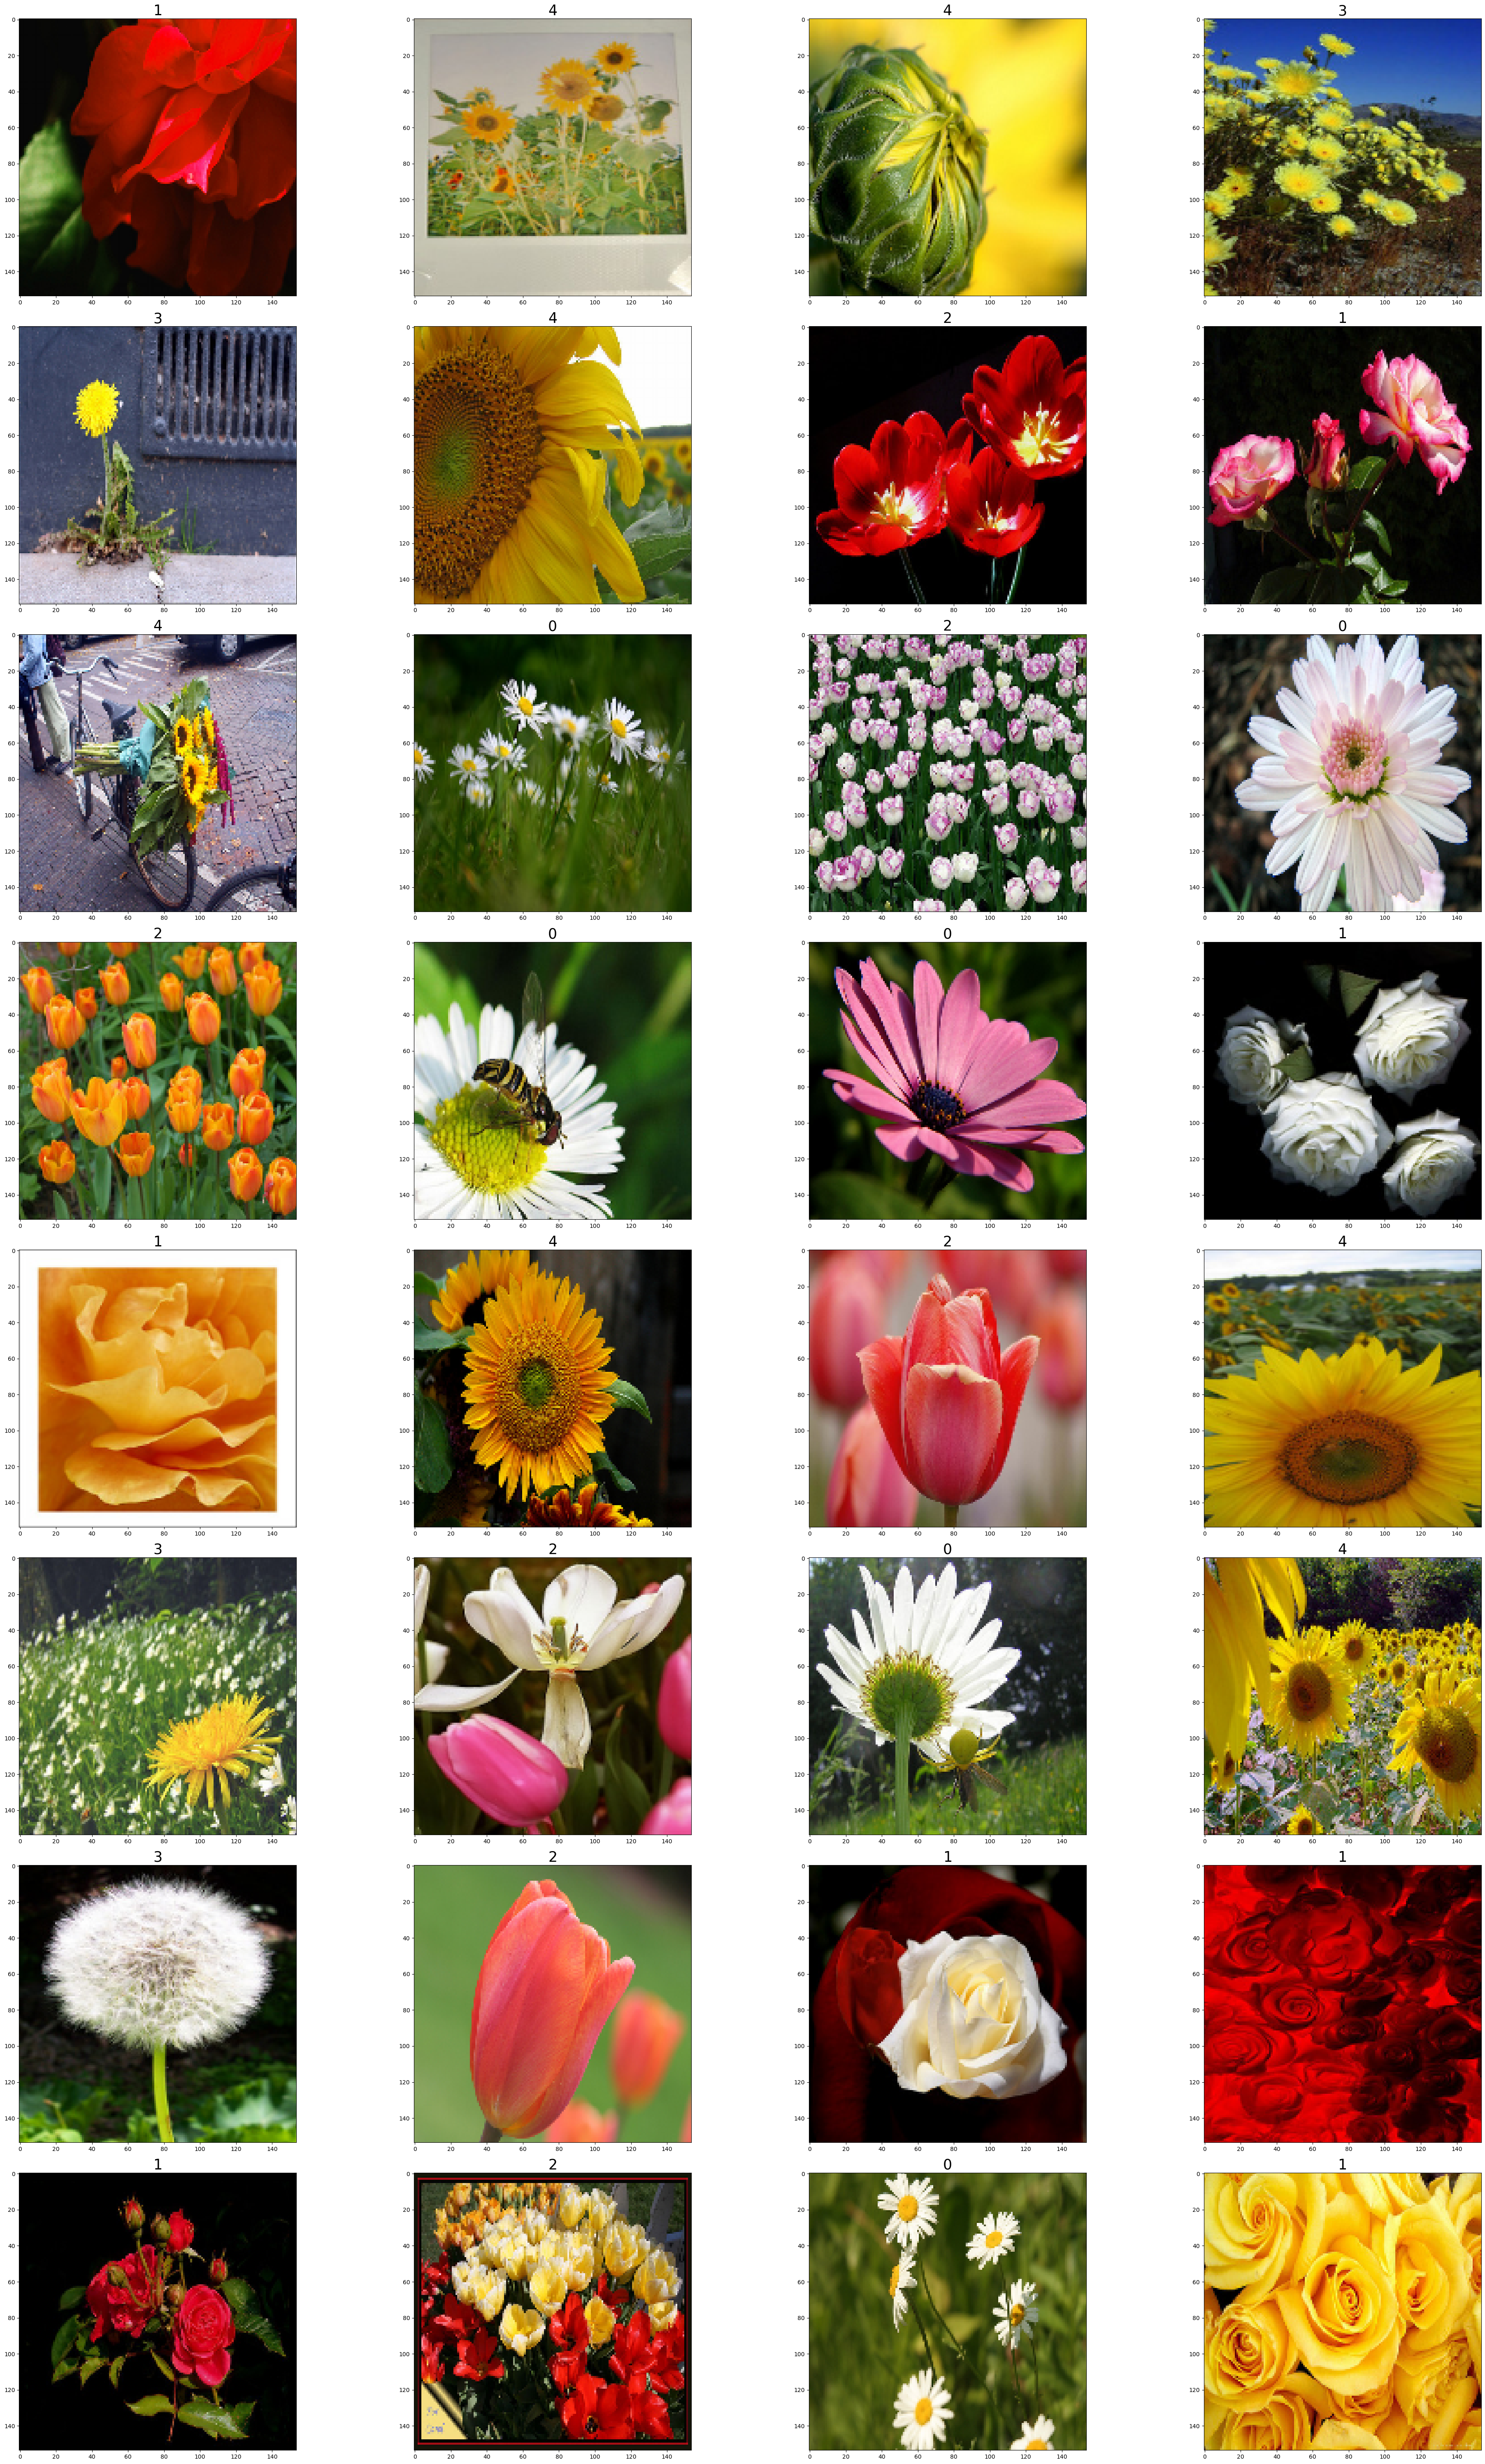

In [44]:
plt.figure(figsize=(40,60))
torch.manual_seed(1)
x,y = next(iter(data))
for i in range(32):
    plt.subplot(8,4,i+1)
    plt.title(y[i].item(), size=25)
    plt.imshow(x[i].permute(1,2,0))
plt.tight_layout()

## Model

In [45]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=0))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('conv2_1', nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('conv3', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))
model.add_module('relu4', nn.ReLU())
model.add_module('pool4', nn.AvgPool2d(kernel_size=19))
model.add_module('flatten', nn.Flatten(1))
model.add_module('fc1', nn.Linear(in_features=256, out_features=64))
model.add_module('relu5', nn.ReLU())
model.add_module('fc2', nn.Linear(in_features=64, out_features=32))
model.add_module('relu6', nn.ReLU())
model.add_module('fc3', nn.Linear(in_features=32, out_features=5))
model

Sequential(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=19, stride=19, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu6): ReLU()
  (fc3): Linear(in_features=32, out_features=5, bias=True)
)

In [46]:
dd = torch.ones(size=(16,3, 154, 154)).to(torch.float32)
dd.shape

torch.Size([16, 3, 154, 154])

In [47]:
model(dd)

tensor([[-0.1641,  0.1970, -0.0781,  0.0908,  0.0319],
        [-0.1641,  0.1970, -0.0781,  0.0908,  0.0319],
        [-0.1641,  0.1970, -0.0781,  0.0908,  0.0319],
        [-0.1641,  0.1970, -0.0781,  0.0908,  0.0319],
        [-0.1641,  0.1970, -0.0781,  0.0908,  0.0319],
        [-0.1641,  0.1970, -0.0781,  0.0908,  0.0319],
        [-0.1641,  0.1970, -0.0781,  0.0908,  0.0319],
        [-0.1641,  0.1970, -0.0781,  0.0908,  0.0319],
        [-0.1641,  0.1970, -0.0781,  0.0908,  0.0319],
        [-0.1641,  0.1970, -0.0781,  0.0908,  0.0319],
        [-0.1641,  0.1970, -0.0781,  0.0908,  0.0319],
        [-0.1641,  0.1970, -0.0781,  0.0908,  0.0319],
        [-0.1641,  0.1970, -0.0781,  0.0908,  0.0319],
        [-0.1641,  0.1970, -0.0781,  0.0908,  0.0319],
        [-0.1641,  0.1970, -0.0781,  0.0908,  0.0319],
        [-0.1641,  0.1970, -0.0781,  0.0908,  0.0319]],
       grad_fn=<AddmmBackward0>)

In [49]:
loss_fn = nn.CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=0.033, momentum=0.9)

## Train loop

In [50]:
def train( model, epoch, data, data_vl,PATH="model_vanilla.pt"):
    train_loss = [0] * epoch
    train_accuracy = [0] * epoch
    valid_loss = [0] * epoch
    valid_accuracy = [0] * epoch
    low_val_loss = 1000
    for i in range(epoch):
        for x_batch, y_batch in data:
            x_batch = x_batch.to('mps')
            y_batch = y_batch.to('mps')
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss[i] += loss.item() * x_batch.size(0)
            softmax_pred = torch.softmax(pred, axis=1)
            #print((softmax_pred))
            is_crt = torch.sum(torch.argmax(softmax_pred, axis=1) == y_batch).cpu()
            train_accuracy[i] += is_crt.to(torch.float32).item()
            
        train_loss[i] /= len(data.dataset)
        train_accuracy[i] /= len(data.dataset)
        
        with torch.no_grad():
            for x_batch, y_batch in data_vl:
                x_batch = x_batch.to('mps')
                y_batch = y_batch.to('mps')
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                valid_loss[i] += loss.item() * x_batch.size(0)
                softmax_pred = torch.softmax(pred, axis=1)
                is_crt = (torch.argmax(softmax_pred, axis=1) == y_batch).sum().cpu()
                valid_accuracy[i] += is_crt.item()
            valid_loss[i] /= len(data_vl.dataset)
            valid_accuracy[i] /= len(data_vl.dataset)
            
        if valid_loss[i] < low_val_loss:
            torch.save({
            'epoch': i +1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_loss[i],
            }, PATH)
            low_val_loss = valid_loss[i]
        print(f'Epoch {i+1} accuracy: {train_accuracy[i]:.4f} val_accuracy:{valid_accuracy[i]:.4f}')
        print(f'Epoch {i+1} loss: {train_loss[i]:.4f} val_loss:{valid_loss[i]:.4f}')
        print()

    return train_loss, train_accuracy, valid_loss, valid_accuracy

In [51]:
train_loss, train_accuracy, valid_loss, valid_accuracy = train(model.to('mps'), 150, data, data_vl)

Epoch 1 accuracy: 0.2100 val_accuracy:0.1500
Epoch 1 loss: 1.6161 val_loss:1.6328

Epoch 2 accuracy: 0.2100 val_accuracy:0.1500
Epoch 2 loss: 1.6129 val_loss:1.6291

Epoch 3 accuracy: 0.2100 val_accuracy:0.1500
Epoch 3 loss: 1.6105 val_loss:1.6253

Epoch 4 accuracy: 0.2100 val_accuracy:0.1500
Epoch 4 loss: 1.6088 val_loss:1.6253

Epoch 5 accuracy: 0.2100 val_accuracy:0.1500
Epoch 5 loss: 1.6083 val_loss:1.6259

Epoch 6 accuracy: 0.2100 val_accuracy:0.1500
Epoch 6 loss: 1.6083 val_loss:1.6260

Epoch 7 accuracy: 0.2100 val_accuracy:0.1500
Epoch 7 loss: 1.6077 val_loss:1.6244

Epoch 8 accuracy: 0.2100 val_accuracy:0.1500
Epoch 8 loss: 1.6074 val_loss:1.6245

Epoch 9 accuracy: 0.2133 val_accuracy:0.1500
Epoch 9 loss: 1.6072 val_loss:1.6257

Epoch 10 accuracy: 0.1900 val_accuracy:0.1900
Epoch 10 loss: 1.6074 val_loss:1.6258

Epoch 11 accuracy: 0.2133 val_accuracy:0.1900
Epoch 11 loss: 1.6069 val_loss:1.6232

Epoch 12 accuracy: 0.2133 val_accuracy:0.1900
Epoch 12 loss: 1.6071 val_loss:1.6217

Epoch 98 accuracy: 0.5900 val_accuracy:0.5200
Epoch 98 loss: 0.9069 val_loss:1.1677

Epoch 99 accuracy: 0.5667 val_accuracy:0.5100
Epoch 99 loss: 0.9730 val_loss:1.2260

Epoch 100 accuracy: 0.6133 val_accuracy:0.5300
Epoch 100 loss: 0.8750 val_loss:1.1517

Epoch 101 accuracy: 0.5833 val_accuracy:0.5600
Epoch 101 loss: 0.8951 val_loss:1.1855

Epoch 102 accuracy: 0.5867 val_accuracy:0.4900
Epoch 102 loss: 0.9306 val_loss:1.1346

Epoch 103 accuracy: 0.5600 val_accuracy:0.5400
Epoch 103 loss: 0.9631 val_loss:1.2034

Epoch 104 accuracy: 0.6067 val_accuracy:0.4800
Epoch 104 loss: 0.9185 val_loss:1.3441

Epoch 105 accuracy: 0.6400 val_accuracy:0.6200
Epoch 105 loss: 0.8603 val_loss:1.1583

Epoch 106 accuracy: 0.6133 val_accuracy:0.5100
Epoch 106 loss: 0.8616 val_loss:1.1673

Epoch 107 accuracy: 0.6167 val_accuracy:0.4200
Epoch 107 loss: 0.9077 val_loss:1.3428

Epoch 108 accuracy: 0.6167 val_accuracy:0.4400
Epoch 108 loss: 0.9356 val_loss:1.2950

Epoch 109 accuracy: 0.5967 val_accuracy:0.5400


In [56]:
checkpoint = torch.load("model_vanilla.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
epoch, loss

(123, 1.0619414567947387)

In [57]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [58]:
data_tst = DataLoader(data_test, 100, False)
test_data = next(iter(data_tst))[0]
model = model.to('cpu')
y_pred = model(test_data)
# print(y_pred.shape)
y_pred = torch.argmax(torch.softmax(y_pred, axis=1),axis=1)
y_test = next(iter(data_tst))[1]

In [59]:
p = precision_score(y_test, y_pred, average = 'weighted')
print(f"Precision: {p}")

r = recall_score(y_test, y_pred , average = 'weighted')
print(f"Recall: {r}")

f1 = f1_score( y_test, y_pred, average = 'weighted')
print(f"F1-score: {f1}")

Precision: 0.606618149292568
Recall: 0.54
F1-score: 0.5225109474009583


## Doubt - (to check)
- Using Adam loss gives big error value